In [2]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import glob
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import imageio
import PIL
import pathlib
import time
# from google.colab import drive

In [2]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
(train_images, train_labels),(test_images, test_labels) = keras.datasets.fashion_mnist.load_data()
train_images.shape

(60000, 28, 28)

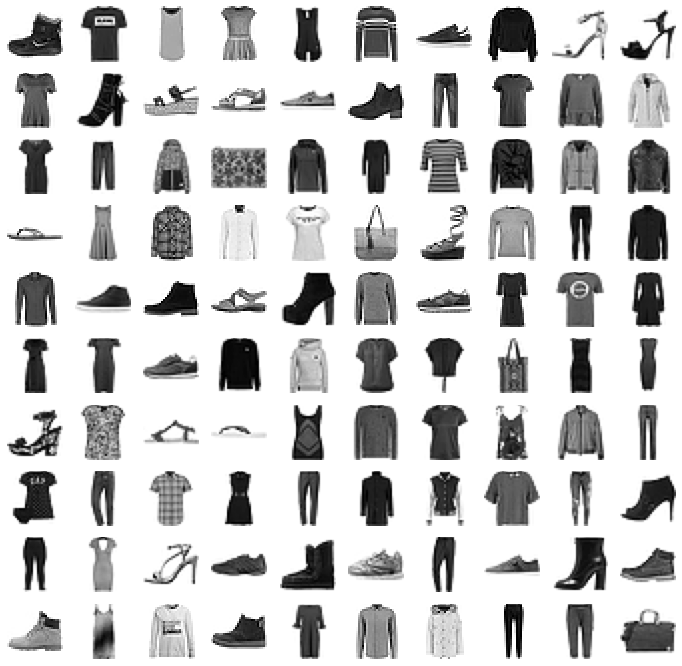

In [4]:
plt.figure(figsize=(12,12))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(train_images[i], cmap='gray_r')
    plt.axis('off')

plt.show()

In [5]:
train_images = train_images.reshape(-1, 28, 28, 1)

In [6]:
train_images = (train_images - 127.5) / 127.5
train_ = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(64)

In [7]:
train_dataset = train_.take(100)

In [8]:
def convert(img, label):
    label = tf.cast(label, dtype=tf.int64)
    img = tf.cast(img, dtype=tf.float32)
    return img, label
train_dataset = train_dataset.map(convert)

In [9]:
train_dataset

<MapDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [10]:
def make_discriminator_wl(num_labels=10):
    inputs = keras.Input(shape=(1,))
    
    # embedding layers
    li = layers.Embedding(num_labels, 50)(inputs)
    li = layers.Dense(784)(li)
    li = layers.Reshape((28, 28, 1))(li)
    
    image_input = keras.Input(shape=(28, 28, 1))
    
    merge = layers.Concatenate()([image_input, li])
    # downsampling
    x = layers.Conv2D(64, (5, 5), strides=(2, 2))(merge)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    # downsampling
    x = layers.Conv2D(128, (5, 5), strides=(2, 2))(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)
    
    # classifier
    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)
    model = keras.Model(inputs=[image_input, inputs], outputs=x)

    return model

In [11]:
disc_wl = make_discriminator_wl()
disc_wl.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 50)        500         ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1, 784)       39984       ['embedding[0][0]']              
                                                                                                  
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                              

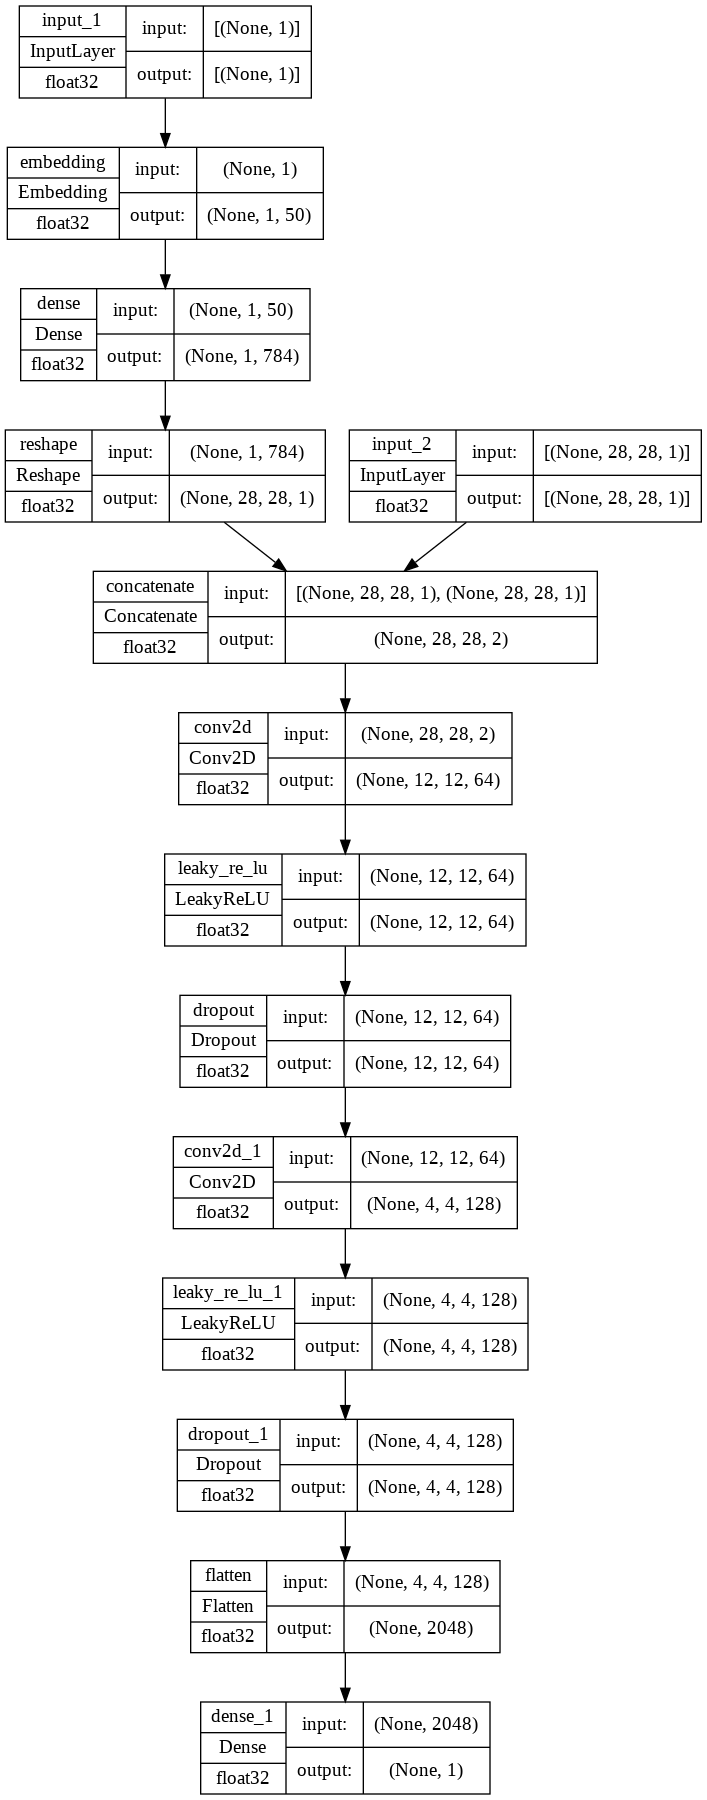

In [12]:
keras.utils.plot_model(disc_wl, show_shapes=True, show_dtype=True)

In [13]:
def make_generator_wl(num_classes=10):
    inputs = keras.Input(shape=(1,))
    li = layers.Embedding(num_classes, 50)(inputs)
    li = layers.Dense(7*7*1)(li)
    li = layers.Reshape((7, 7, 1))(li)
    
    gen = keras.Input(shape=(100,))
    nodes = 7*7*128
    x = layers.Dense(nodes)(gen)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((7, 7, 128))(x)
    
    merge = layers.Concatenate()([x, li])
    
    # upsampling
    x = layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same')(merge)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    # upsampling
    x = layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    
    # upsampling
    x = layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh', use_bias=False)(x)
    
    model = keras.Model(inputs=[gen, inputs], outputs=x)
    return model

In [14]:
gen_wl = make_generator_wl()
gen_wl.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 dense_3 (Dense)                (None, 6272)         633472      ['input_4[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 50)        500         ['input_3[0][0]']                
                                                                                            

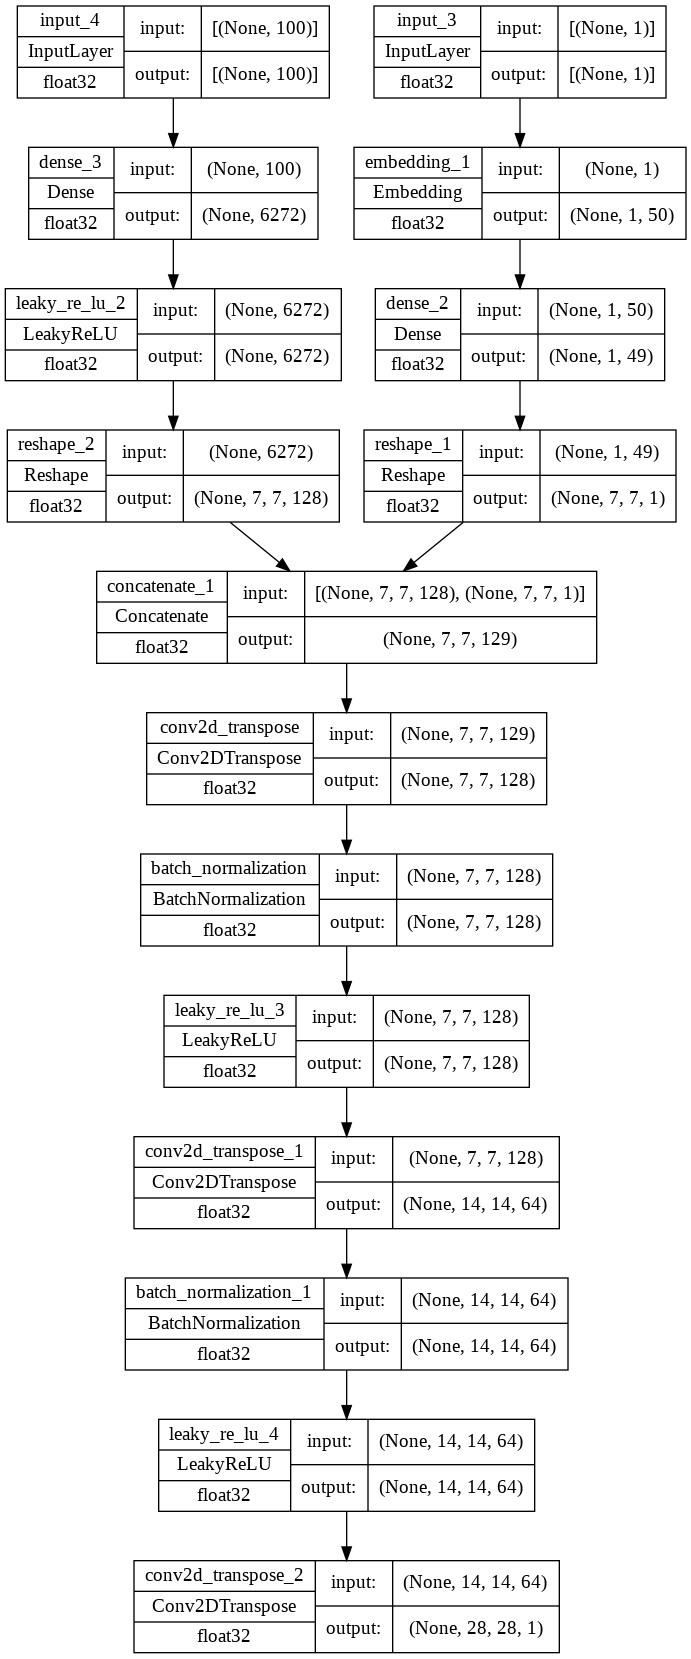

In [15]:
keras.utils.plot_model(gen_wl, show_dtype=True, show_shapes=True)

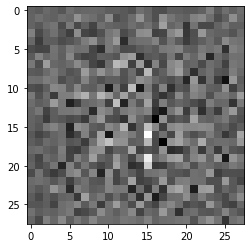

In [16]:
def generate_fake(n_samples, n_classes, latent_dim):
    labels = np.random.randint(0, n_classes, n_samples)
    noise = tf.random.normal([n_samples, latent_dim])
    return noise, labels

noise, labels = generate_fake(1, 10, 100)

gen_img = gen_wl([noise, labels])

plt.imshow(gen_img[0,:,:,0], cmap='gray')

In [17]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def discriminator_loss(self, real, fake):
        real_loss = self.loss_fn(tf.ones_like(real), real)
        fake_loss = self.loss_fn(tf.zeros_like(fake), fake)
        total_loss = real_loss + fake_loss
        return total_loss

    def generator_loss(self, fake):
        fake_loss = self.loss_fn(tf.ones_like(fake), fake)
        return fake_loss

    def train_step(self, batch):
        tr_image, tr_label = batch
        noise, labels = generate_fake(64, 10, 100)
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

            generated_image = self.generator([noise, labels], training=True)

            real = self.discriminator([tr_image, tr_label], training=True)
            fake = self.discriminator([generated_image, labels], training=True)

            gen_loss = self.generator_loss(fake)
            disc_loss = self.discriminator_loss(real, fake)

        gen_grad = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        disc_grad = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.g_optimizer.apply_gradients(zip(gen_grad, self.generator.trainable_variables))
        self.d_optimizer.apply_gradients(zip(disc_grad, self.discriminator.trainable_variables))
        return {"d_loss": disc_loss, "g_loss": gen_loss}

In [18]:
gan = GAN(discriminator=disc_wl, generator=gen_wl, latent_dim=100)

In [19]:
gan.compile(d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
           g_optimizer = keras.optimizers.Adam(learning_rate=0.0001),
           loss_fn=keras.losses.BinaryCrossentropy(from_logits=True))

In [23]:
epochs = 50
seed = tf.random.normal([16, 100])
labels = np.random.randint(0, 10, 16)

In [24]:
path = '/content/drive/My Drive/Colab Notebooks/images3/'

class Generate(keras.callbacks.Callback):
    def __init__(self):
        super(Generate, self).__init__()
        
    def on_epoch_end(self, epoch, logs=None):
        prediction = gen_wl([seed, labels])

        plt.figure(figsize=(4, 4))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            plt.imshow(prediction[i, :, :, 0], cmap='gray')
            plt.axis('off')
            
        plt.savefig(f'{path}/image at epoch {epoch+1}.png')
        plt.show

In [25]:
gan.fit(train_, epochs=50, callbacks=[Generate()])

Output hidden; open in https://colab.research.google.com to view.

In [28]:
gen_wl.save('/content/drive/My Drive/Colab Notebooks/Saved models/gen_wl')
disc_wl.save('/content/drive/My Drive/Colab Notebooks/Saved models/disc_wl')

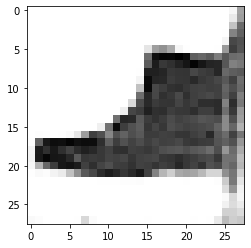

In [49]:
labels = np.array([9])
im = tf.random.normal([1, 100])
gen_img = gen_wl([im, labels])
plt.imshow(gen_img[0,:,:,0], cmap='gray_r')

In [3]:
def last_char(x):
    return x.split('.')[0][-2:]

In [4]:
anim_file = 'dcgan3.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = os.listdir('.\pics3\images3')
    filenames = sorted(filenames, key=last_char)
    for filename in filenames:
        image = imageio.imread('.\\pics3\\images3\\'+filename)
        writer.append_data(image)
    image = imageio.imread('.\\pics3\\images3\\'+filename)
    writer.append_data(image)

C:\Users\SHOCKER\AppData\Local\Temp\ipykernel_11396\1201340012.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('.\\pics3\\images3\\'+filename)
C:\Users\SHOCKER\AppData\Local\Temp\ipykernel_11396\1201340012.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread('.\\pics3\\images3\\'+filename)



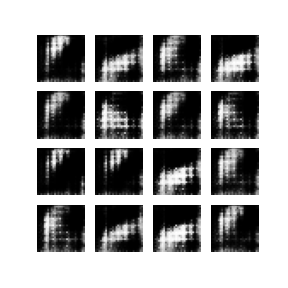

In [5]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)